In [2]:
import os
import jax
import pickle

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=24'
jax.config.update('jax_platform_name', 'cpu')

#from jax.config import config; config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

from brax import envs
from brax.io import html, model
from brax.training import normalization

import flax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output

import optax
import pickle

import matplotlib.pyplot as plt
import numpy as np

from controllers import GruController, MlpController, LinearController

from ce_apg import do_one_rollout, cem_apg, cem

from functools import partial



def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

len(jax.devices())

save_dir = "save_3_cem"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


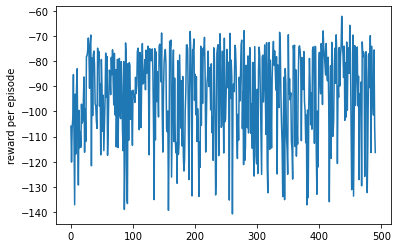

In [5]:
for env_name in ["inverted_pendulum_swingup", "inverted_double_pendulum_swingup", "acrobot", "reacher"]:  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

    episode_length = 500
    action_repeat = 1
    env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
    env = env_fn()

    policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
    print(policy_size)
    policy = GruController(env.observation_size, env.action_size, policy_size)
    pickle.dump(policy, open(f"{save_dir}/{env_name}_policy", 'wb'))

    for i in range(8):
        inference_fn, params, rewards = cem(env_fn, 500, key = jax.random.PRNGKey(i))


        model.save_params(f"{save_dir}/{env_name}_params_{i}", params)
        pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", "wb"))

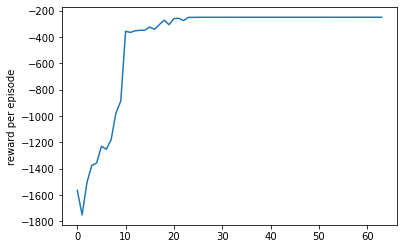

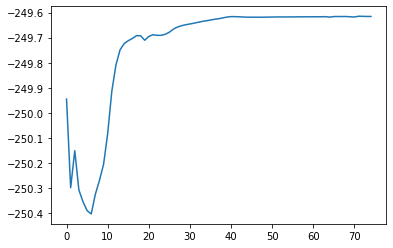

 Iteration 63 --------------------------------
0 : reward: -251.54794311523438 -> -249.6156768798828
1 : reward: -250.270263671875 -> -249.71975708007812
2 : reward: -250.2259979248047 -> -249.72216796875
3 : reward: -251.88128662109375 -> -249.7457275390625
4 : reward: -249.62445068359375 -> -249.812744140625
5 : reward: -250.07986450195312 -> -249.8174285888672
6 : reward: -250.1370849609375 -> -249.851318359375
7 : reward: -250.36712646484375 -> -249.85305786132812
---
8 : reward: -250.57684326171875 -> -249.856689453125
9 : reward: -251.89955139160156 -> -249.867431640625
10 : reward: -759.9486083984375 -> -249.8954620361328
11 : reward: -251.80413818359375 -> -249.91748046875
12 : reward: -250.2324981689453 -> -249.92373657226562
13 : reward: -250.01454162597656 -> -249.9687957763672
14 : reward: -251.0733642578125 -> -249.9941864013672
15 : reward: -250.12274169921875 -> -249.997314453125
16 : reward: -249.79998779296875 -> -250.0033721923828
17 : reward: -250.17807006835938 -> -

In [ ]:
#for env_name in ["inverted_pendulum_swingup" , "acrobot", "inverted_double_pendulum_swingup"]:  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]
save_dir = "save_1_apg"
for env_name in ["inverted_pendulum_swingup", "inverted_double_pendulum_swingup", "acrobot"]:
    episode_length = 500
    action_repeat = 1
    env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
    env = env_fn()

    policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
    print(policy_size)
    policy = GruController(env.observation_size, env.action_size, policy_size)
    pickle.dump(policy, open(f"{save_dir}/{env_name}_policy", 'wb'))
    
    for i in range(8):
        inference_fn, params, rewards = cem_apg(env_fn,
                                                200*75,
                                                key=jax.random.PRNGKey(i),
                                                episode_length = episode_length,
                                                action_repeat = action_repeat,
                                                batch_size = 1,
                                                truncation_length = None,
                                                learning_rate = 5e-4,
                                                clipping = 1e9,
                                                initial_std = 0.05,
                                                eps = 0.0,
                                                normalize_observations=True,
                                                policy = policy
                                               )

        model.save_params(f"{save_dir}/{env_name}_params_{i}", params)
        pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", "wb"))


In [3]:
import ce_apg
policy = pickle.load(open(f"{save_dir}/{env_name}_policy","rb"))
inference_fn = ce_apg.make_inference_fn(
    env.observation_size, env.action_size, True, policy)
params = model.load_params(f"{save_dir}/{env_name}_params_0")

In [4]:

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=5)
state = jit_env_reset(rng=rng)
h0 = np.zeros_like(state.obs)
h = h0

while not state.done:
  rollout.append(state)
  h, act = jit_inference_fn(params, h, state.obs)
  state = jit_env_step(state, act)

HTML(html.render(env.sys, [s.qp for s in rollout]))